In [123]:
import scipy.io as scio
from matplotlib import pyplot as plt
import numpy as np

data = scio.loadmat('data_sets/ex3data1')
x_data = data['X']
y_data = data['y']

print('x_data.shape:', x_data.shape)
print('y_data.shape:', y_data.shape)


x_data.shape: (5000, 400)
y_data.shape: (5000, 1)


<Figure size 432x288 with 0 Axes>

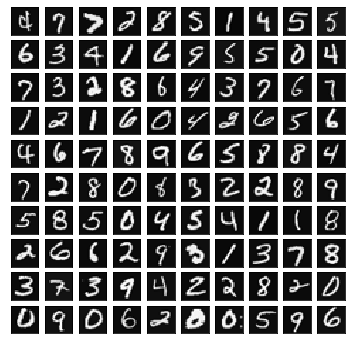

In [124]:
'''
Visualizing the data
'''
def display_data(x):
    plt.figure()
    n = np.round(np.sqrt(x.shape[0])).astype(int)
    # define n*n subplots
    fig, ax = plt.subplots(nrows = n, ncols = n, sharex = True, sharey = True, 
                           figsize = (6, 6))
    for row in range(n):
        for col in range(n):
            ax[row, col].imshow(x[n * row + col].reshape(20, 20).T, cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

shuffle = np.random.permutation(x_data)
x_data_split = shuffle[:100, :]
display_data(x_data_split)


In [125]:
'''
Feedforward propagation
'''
weights = scio.loadmat('data_sets/ex4weights')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

print('theta1.shape:', theta1.shape)
print('theta2.shape:', theta2.shape)


theta1.shape: (25, 401)
theta2.shape: (10, 26)


In [126]:
def g(z):
    return 1 / (1 + np.exp(-z))

def plus_bias(x):
    x = np.mat(x)
    x = np.column_stack((np.ones(x.shape[0]), x))
    x = np.array(x)
    return x

def forward_prob(x, theta1, theta2, num_layer = 3):
    b1 = x
    for i in range(1, num_layer):
        locals()['a' + str(i)] = plus_bias(locals()['b' + str(i)])
        locals()['z' + str(i+1)] = locals()['a' + str(i)] @ locals()['theta' + str(i)].T
        locals()['b' + str(i+1)] = g(locals()['z' + str(i+1)])
    return locals()['b' + str(num_layer)]

In [127]:
'''
Cost function
'''
# make y_data become one-hot labels
def y_data_vec(y):
    y_vec = np.zeros((len(y), np.max(y)))
    for i in range(len(y)):
        y_vec[i, y[i] - 1] = 1
    return y_vec

def unrolling(theta1, theta2):
    return np.concatenate((np.reshape(theta1, theta1.size), np.reshape(theta2, theta2.size)), axis = 0)

def reshapen(theta):
    return np.reshape(theta[:10025], (25, 401)), np.reshape(theta[10025:], (10, 26))

def nnCostFunc(theta, x, y):
    theta1, theta2 = reshapen(theta)
    m = len(y)
    h_x = forward_prob(x, theta1, theta2) # h_x->(5000, 10), y->(5000, 10)
    first_part = -np.multiply(y, np.log(h_x)) - np.multiply((1 - y), np.log(1 - h_x))
    return np.sum(first_part) / m

y_vec = y_data_vec(y_data)
theta = unrolling(theta1, theta2)
print('The cost is about', nnCostFunc(theta, x_data, y_vec))

The cost is about 0.2876291651613189


In [130]:
# Regularized cost function
def nnCostFunc_reg(theta, x, y, L = 1):
    theta1, theta2 = reshapen(theta)
    m = len(y)
    cost = nnCostFunc(theta, x, y)
    reg = (L / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])))
    print('The regularized cost is about', cost + reg)
    return cost + reg

nnCostFunc_reg(theta, x_data, y_vec)

The regularized cost is about 0.38376985909092365


0.38376985909092365

In [131]:
'''
Backpropagation
'''
def g_gradient(z):
    return g(z) * (1 - g(z))

print('As z equals to 0, the sigmoid gradient is', g_gradient(0))

As z equals to 0, the sigmoid gradient is 0.25


In [132]:
def rand_initialize_weights(L_in, L_out, epsilon):
    return np.random.uniform(-epsilon, epsilon, L_in * L_out)

def forward_pass(x_one, theta1, theta2):
    a1 = plus_bias(x_one) # a1->(1, 401)
    z2 = a1 @ (theta1.T) # z2->(1, 25)
    a2 = plus_bias(g(z2)) # a2->(1, 26)
    z3 = a2 @ (theta2.T) # z3->(1, 10)
    a3 = g(z3) # a3->(1, 10)
    return a1, z2, a2, z3, a3

# don't concatenate two matrix, and then add them with other vectors, which results that the speed of running is super slow.
def back_propagation(theta, x, y):
    theta1, theta2 = reshapen(theta)
    Delta = np.zeros(len(theta))
    Delta1 = np.zeros(theta1.shape)
    Delta2 = np.zeros(theta2.shape)
    m = x.shape[0]
    # the for-loop can be replaced by matrix operations, which will increase the speed of running.
    for i in range(m):
        a1, z2, a2, z3, a3 = forward_pass(x[i, :], theta1, theta2)
        # delta3->(1, 10)
        delta3 = a3 - y[i, :]
        # theta2->(10, 26) delta3->(1, 10) z2->(1, 25) delta2->(1, 25)
        delta2 = delta3 @ theta2[:, 1:] * g_gradient(z2)
        
        Delta2 += delta3.T @ a2 # Delta2->(10, 26)
        Delta1 += delta2.T @ a1 # Delta1->(25, 401)
    Delta = unrolling(Delta1, Delta2)    
    return Delta / m

In [133]:
'''
Gradient checking
Note that you should eliminate the gradient checking before you have guaranteed
that the back propagation is correct, because the calculation of gradient is expensive.
'''
def numerical_gradient(theta, x, y):
    num_grad = np.zeros(theta.shape)
    epsilon = np.zeros(theta.shape)
    e = 1e-4
    for i in range(len(theta)):
        epsilon[i] = e
        loss1 = nnCostFunc(theta - epsilon, x, y)
        loss2 = nnCostFunc(theta + epsilon, x, y)
        num_grad[i] = (loss2 - loss1) / (2 * e)
        epsilon[i] = 0
    return num_grad

# predict_gradient = back_propagation(theta, x_data, y_vec)
# num_gradient = numerical_gradient(theta, x_data, y_vec)
# diff = np.linalg.norm(predict_gradient - num_gradient)
# print('The result of gradient checking is ', diff)

In [134]:
'''
Regularized Back Propagation
'''
def back_propagation_reg(theta, x, y, L):
    Delta = back_propagation(theta, x, y)
    theta1, theta2 = reshapen(theta)
    D1, D2 = reshapen(Delta)
    theta1[:, 0] = 0 # don't regularized the first column of theta
    theta2[:, 0] = 0
    D1 = D1 + L/len(x)*theta1
    D2 = D2 + L/len(x)*theta2  
    return unrolling(D1, D2)

In [135]:
'''
Gradient checking to account for regularized back propagation
'''
def numerical_gradient_reg(theta, x, y, L):
    num_grad = np.zeros(theta.shape)
    epsilon = np.zeros(theta.shape)
    e = 1e-4
    for i in range(len(theta)):
        epsilon[i] = e
        loss1 = nnCostFunc_reg(theta - epsilon, x, y, L)
        loss2 = nnCostFunc_reg(theta + epsilon, x, y, L)
        num_grad[i] = (loss2 - loss1) / (2 * e)
        epsilon[i] = 0
    return num_grad

# predict_gradient_reg = back_propagation_reg(theta, x_data, y_vec, 1)
# num_gradient_reg = numerical_gradient_reg(theta, x_data, y_vec, 1)
# diff_reg = np.linalg.norm(predict_gradient_reg - num_gradient_reg)
# print('The result of gradient checking is ', diff_reg)

In [136]:
'''
Learning parameters using scipy.optimize.minimize
'''
import scipy.optimize as opt

L = 1
theta1_rand = rand_initialize_weights(401, 25, 0.12)
theta2_rand = rand_initialize_weights(26, 10, 0.12)
theta_rand = unrolling(theta1_rand, theta2_rand)
result = opt.minimize(fun = nnCostFunc_reg, 
                      x0 = theta_rand, 
                      args = (x_data, y_vec, L), 
                      method = 'Newton-CG', 
                      jac = back_propagation_reg,
                      options = {'maxiter': 400, 'disp': True}
                      )


The regularized cost is about 6.778882844156221
The regularized cost is about 3.4303326420477744
The regularized cost is about 3.287706370778136
The regularized cost is about 3.250622942316167
The regularized cost is about 3.236013763895857
The regularized cost is about 3.2256639320519978
The regularized cost is about 3.213545062651617
The regularized cost is about 3.1975292452968254
The regularized cost is about 3.1813900898745437
The regularized cost is about 3.163792659427934
The regularized cost is about 3.143182036693817
The regularized cost is about 3.119556399473396
The regularized cost is about 3.092798804261869
The regularized cost is about 3.062597549518024
The regularized cost is about 3.0291000166910327
The regularized cost is about 2.9920972209993133
The regularized cost is about 2.951998755209363
The regularized cost is about 2.9089363935860435
The regularized cost is about 2.8632235821776386
The regularized cost is about 2.8155524501987936
The regularized cost is about 2

In [137]:
'''
Prediction
'''
def predict(prob):
    y_predict = np.zeros((prob.shape[0], 1))
    for i in range(prob.shape[0]):
        y_predict[i] = np.argmax(prob[i, :]) + 1
    return y_predict

def accuracy(y_pred, y):
    m = y.size
    count = 0 
    for i in range(m):
        if y_pred[i] == y[i]:
            count = count + 1
    return count / m

theta1_rand, theta2_rand = reshapen(result['x'])
h_x = forward_prob(x_data, theta1_rand, theta2_rand)
y_pred = predict(h_x)
print('accuracy = {}%'.format(accuracy(y_pred, y_data) * 100))


accuracy = 95.54%


<Figure size 432x288 with 0 Axes>

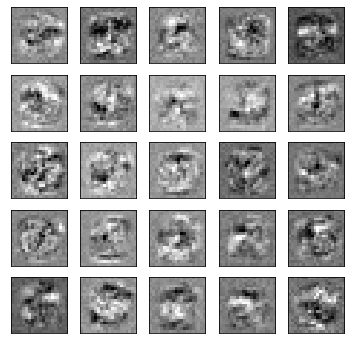

In [138]:
'''
Visualizing the hidden layer
'''
display_data(theta1_rand[:, 1:])